In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.linalg import inv
from collections import defaultdict
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
%matplotlib inline

In [2]:
def collect_x(df, x_cols):
    mat = []
    mat.append(df[x_cols].values)
    return np.asarray(mat)

In [3]:
def fit_linear(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    y = y.T
    A = []
    A = np.ones((len(x), 2))
    for i in range(0, len(x)):
        A[i][1] = x[i]
    u = np.matmul(np.matmul(inv(np.matmul(A.T, A)), A.T), y)
    return u[-1], u[0]

In [4]:
crime = pd.read_csv('./crime.csv')
crime.columns = ['year', 'lga', 'offence', 'sub', 'subsub', 'incidents', 'rate']

In [5]:
def clean_data(df):
    df['incidents'] = df['incidents'].apply(lambda x: int(x.replace(',', '')))
    df['rate'] = df['rate'].apply(lambda x: float(x.replace(',', '')))
    return df

In [6]:
crime = clean_data(crime)

In [7]:
def filter_lga(df, col='lga'):
    df[col] = df[col].apply(lambda x: x.upper())
    df[col] = df[col].apply(lambda x: 
                            x.replace('CITY', '')
                            .replace('OF', '')
                            .replace('-', ' ')
                            .replace('RURAL', '')
                            .replace("SHIRE", '')
                            .strip())
    return df

In [8]:
def get_overlap(df1, df2):
    return set(df1['lga']).intersection(set(df2['lga']))

In [9]:
def common_cols(*args, col='lga'):
    if len(args) < 2:
        print("Need more than 1")
        return -1
    ddf = args[0]
    ndf = args[1]
    common = set(ddf[col]).intersection(set(ndf[col]))
    for i in range(3,len(args)):
        ndf = args[i]
        common = common.intersection(set(ndf[col]))
    return common
        

In [10]:
def set_game_cols(df):
    df.columns = ['lga', 'lga_code', 'reg', 'net', 'dis_score', 'dis_rank_s', 'dis_rank_c', 'dis_rank_m', 'advdis_score', 'advdis_rank_s', 'advdis_rank_c', 'advdis_rank_m', 'pop', 'per_venue', 'per_1000_adults', 'per_adult', 'workforce', 'unemployed', 'urate']
    return df

In [11]:
gmbling17 = pd.read_csv('./gambling-2017.csv')
gmbling17 = set_game_cols(gmbling17)
gmbling17 = filter_lga(gmbling17, col='lga')
common = common_cols(gmbling17, crime, col='lga')
gmbling17 = gmbling17[gmbling17['lga'].isin(common)]
crime = crime[crime['lga'].isin(common)]
crime17 = crime[crime['year']==2017]

In [12]:
def gambling_per_lga(df):
    y = df.groupby('lga').sum().reset_index().drop('year', axis=1).sort_values('lga')['rate']
    x = df.groupby('lga').sum().reset_index().drop('year', axis=1).sort_values('lga')['lga']
    return pd.DataFrame({"LGA_NAME16": x, "RATE": y})

In [13]:
def exp_vs_crime():
    y = crime17.groupby('lga').sum().reset_index().drop('year', axis=1).sort_values('lga')['rate']
    x = gmbling17.sort_values('lga')['per_adult']
    x = x.apply(lambda x: x.replace(',', '').strip())
    x = x.apply(lambda x: np.nan if '-' in x else float(x))
    x = list(x)
    y = list(y)
    nx = []
    ny = []
    for i in range(0,len(x)):
        if np.isnan(x[i]):
            continue
        else:
            nx.append(x[i])
            ny.append(y[i])
    print(pearsonr(nx, ny))
    plt.scatter(nx,ny)
    x = np.linspace(min(nx), max(nx))
    m, b = fit_linear(nx, ny)
    y = (m*x) +b
    plt.plot(x, y)
    plt.xlabel('Expenditure per adult')
    plt.ylabel('Crime Rate per 100,000')
    plt.savefig('exp_crime.png', dpi=1080)
    plt.show()

(0.45025910781391804, 0.0001168631207104621)


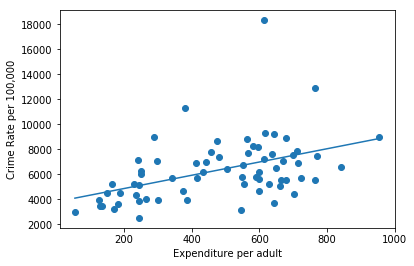

In [14]:
exp_vs_crime()

In [15]:
def unem_vs_exp_ad():
    y = gmbling17.sort_values('lga')['per_adult']
    x = gmbling17.sort_values('lga')['urate']
    x = x.apply(lambda x: float(x.replace('%', '').strip()))
    y = y.apply(lambda x: np.nan if '-' in x else float(x))
    df = pd.DataFrame({'x': x, 'y': y})
    df = df.dropna()
    print(pearsonr(df['x'], df['y']))
    plt.scatter(df['x'],df['y'])
    x = df['x']
    y = df['y']
    m, b = fit_linear(x, y)
    x = np.linspace(min(x), max(x))
    y = (m*x) + b
    plt.plot(x, y)
    plt.xlabel('Unemployment rate')
    plt.ylabel('Expenditure per adult')
    plt.savefig('urate_exp.png', dpi=1080)
    plt.show()

(0.6221642144560382, 1.4830349778724958e-08)


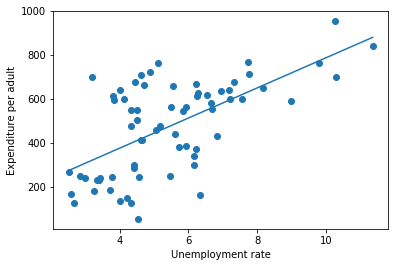

In [16]:
unem_vs_exp_ad()

(0.3823434665533191, 0.0012925553462341571)


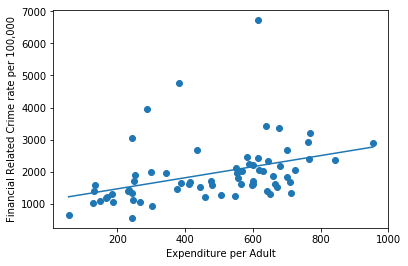

In [17]:
theft17 = crime17[crime17['sub'].apply(lambda x: 'B40' in x)]
y = theft17.groupby('lga').sum().reset_index().sort_values('lga')['rate']
x = gmbling17.sort_values('lga')['per_adult']
x = x.apply(lambda x: x.replace(',', ''))
x = x.apply(lambda x: np.nan if '-' in x else float(x))
x = list(x)
y = list(y)

nx = []
ny = []
for i in range(0, len(x)):
    if np.isnan(x[i]):
        continue
    else:
        nx.append(x[i])
        ny.append(y[i])
print(pearsonr(nx, ny))
plt.scatter(nx, ny)
x = np.linspace(min(nx), max(nx))
m, b = fit_linear(nx, ny)
y = (m*x) +b
plt.plot(x, y)
plt.xlabel('Expenditure per Adult')
plt.ylabel('Financial Related Crime rate per 100,000')
plt.savefig('exp_fcrime.png', dpi=1080)
plt.show()

In [18]:
def get_noise_outliers_q1_q3(s):
    med = s.median()
    lower = s[s < med]
    upper = s[s > med]
    iqr = upper.median() - lower.median()
    noise_upper = upper.median() + (iqr*1.5)
    noise_lower = lower.median() - (iqr*1.5)
    max_upper  =  upper.median() + (iqr*3)
    max_lower = lower.median() - (iqr*3)
    noise = sum(((s < noise_lower) & (s > max_lower))) + sum(((s > noise_upper) & (s < max_upper)))
    outliers = sum( s > max_upper) + sum(s < max_lower)
    return noise, outliers, lower.median(), upper.median()

In [19]:
lga_crime = crime17.groupby('lga').sum().reset_index().drop('year', axis=1)

In [20]:
s = gmbling17['dis_score'].apply(lambda x: float(x))
get_noise_outliers_q1_q3(s)

(0, 0, 962.1300000000001, 1025.04)

In [21]:
s = gmbling17['per_venue'].apply(lambda x: np.nan if '-' in x else float(x.replace(',', '')))
n,o,mi,ma = get_noise_outliers_q1_q3(s)
s = s.dropna()
print(100*n/len(s), 100*o/len(s))
print(mi, ma)

2.9411764705882355 1.4705882352941178
5714.0 11616.0


In [22]:
s = gmbling17['per_adult'].apply(lambda x: np.nan if '-' in x else float(x.replace(',', '')))
n,o,mi,ma = get_noise_outliers_q1_q3(s)
s = s.dropna()
print(100*n/len(s), 100*o/len(s))
print(mi, ma)

0.0 0.0
259.06 642.855


In [23]:
s = gmbling17['urate'].apply(lambda x: np.nan if '-' in x else float(x.replace(',', '').replace('%', '')))
n,o,mi,ma = get_noise_outliers_q1_q3(s)
s = s.dropna()
print(100*n/len(s), 100*o/len(s))
print(mi, ma)

5.194805194805195 0.0
4.015 6.265000000000001


In [24]:
s = lga_crime['rate']
get_noise_outliers_q1_q3(s)
n,o,mi,ma = get_noise_outliers_q1_q3(s)
s = s.dropna()
print(100*n/len(s), 100*o/len(s))
print(mi, ma)

1.2987012987012987 1.2987012987012987
4289.2 7299.8


In [25]:
s = lga_crime['incidents']
s = s.dropna()
get_noise_outliers_q1_q3(s)
n,o,mi,ma = get_noise_outliers_q1_q3(s)

print(100*n/len(s), 100*o/len(s))
print(mi, ma)

1.2987012987012987 0.0
879.0 8220.0


In [26]:
df = gambling_per_lga(crime17)
df.to_csv("./lga-gambling-rate-clean.csv") # This is the dataframe where we save a csv file to be used in choropleth 

In [47]:
df = pd.read_csv('./gambling-2017.csv')
df = filter_lga(df, col='LGA Name')
df['lga'] = df['LGA Name']

ncrime = crime17

common = common_cols(df, ncrime, 'lga')

df = df[df['lga'].isin(common)]
ncrime = ncrime[ncrime['lga'].isin(common)]

df = df.sort_values(by='lga')
ncrime = ncrime.groupby('lga').sum().reset_index()
ncrime = ncrime.sort_values(by='lga')

df = pd.merge(df, ncrime, on='lga')

#df['Region'] = df['Region'].apply(lambda x: 1 if "M" in x else 0)
df['DIS Score '] = df['DIS Score '].apply(lambda x: float(x))
df['per Venue 2017'] = df['per Venue 2017'].apply(lambda x: np.nan if '-' in x else float(x.replace(',', '')))
df['per Adult 2017'] = df['per Adult 2017'].apply(lambda x: np.nan if '-' in x else float(x))
df['Unemployment rate '] = df['Unemployment rate '].apply(lambda x: np.nan if '-' in x else float(x.replace('%', '')))
df = df.dropna()
df = df[['rate', 'lga', 'DIS Score ', 'per Venue 2017', 'per Adult 2017', 'Unemployment rate ']]

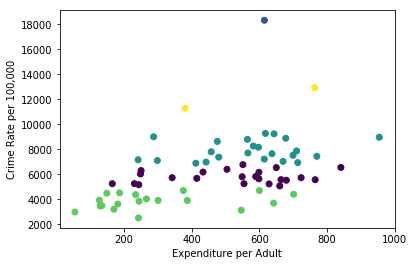

In [55]:
mat = df[[ 'rate', 'per Adult 2017',]].as_matrix()
kmeans = KMeans(n_clusters=5, random_state=0).fit(mat)
plt.scatter(df['per Adult 2017'],df['rate'], c=kmeans.labels_)
plt.ylabel('Crime Rate per 100,000')
plt.xlabel('Expenditure per Adult')
plt.savefig('kmeans.png', dpi=1080)
plt.show()

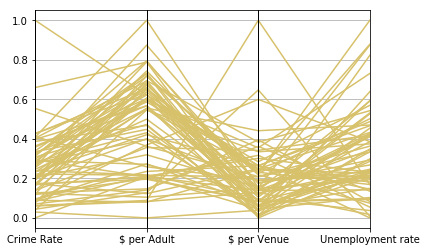

In [29]:
def norm(df):
    df_min = df.min()
    df_max = df.max()
    return (df-df_min)/(df_max-df_min)

ndf = df
ndf['empty'] = ''
ndf['DIS Score '] = norm(ndf['DIS Score '])
ndf['per Venue 2017'] = norm(ndf['per Venue 2017'])
ndf['per Adult 2017'] = norm(ndf['per Adult 2017'])
ndf['Unemployment rate '] = norm(ndf['Unemployment rate '])
ndf['rate'] = norm(df['rate'])
cols = ndf.columns
ndf = ndf[['rate', 'per Adult 2017', 'per Venue 2017', 'Unemployment rate ', 'empty']]
ndf.columns = ['Crime Rate', '$ per Adult', '$ per Venue', 'Unemployment rate', 'empty']
pd.plotting.parallel_coordinates(ndf, 'empty')
plt.savefig('pcoords.png', dpi=1080)
plt.show()